In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.weight'] = 'bold'  
import pandas as pd
results = []

In [ ]:
"""
Nonequispaced DCT/DST via least squares on cosine/sine bases.

- NDCT:  use cos(k*pi*x), k=0..K  (even extension, suitable for functions not vanishing at boundaries)
- NDST:  use sin(k*pi*x), k=1..K  (odd extension, suitable for functions approximately zero at both ends)

Dependencies: numpy, matplotlib
"""

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# -------------------------- Bases & Solver --------------------------

def ndct_basis(x, K):
    """
    Construct the NDCT design matrix A whose columns are cos(k*pi*x), k=0..K.
    
    Parameters
    ----------
    x : array_like, shape (m,)
        Sampling points in the range [0, 1].
    K : int
        Maximum frequency index.
    
    Returns
    -------
    A : ndarray, shape (m, K+1)
        Design matrix of cosine basis functions.
    """
    x = np.asarray(x).reshape(-1)
    ks = np.arange(K + 1)                         # 0..K
    return np.cos(np.pi * np.outer(x, ks))        # m x (K+1)

def lsq_fit(A, y, lam=0.0):
    """
    Solve the least-squares (or ridge-regularized) problem:
        min ||A c - y||_2^2 + lam ||c||_2^2

    Parameters
    ----------
    A : ndarray
        Design matrix.
    y : ndarray
        Target vector.
    lam : float, optional
        Ridge regularization coefficient. Default is 0 (ordinary least squares).

    Returns
    -------
    c : ndarray
        Coefficient vector.
    """
    y = np.asarray(y).reshape(-1)
    n = A.shape[1]
    if lam and lam > 0:
        # Stable ridge regression solution: (A^T A + lam I) c = A^T y
        ATA = A.T @ A
        ATy = A.T @ y
        return np.linalg.solve(ATA + lam * np.eye(n), ATy)
    else:
        return np.linalg.lstsq(A, y, rcond=None)[0]

# -------------------------- Models --------------------------

@dataclass
class NDCTModel:
    coeffs: np.ndarray
    K: int
    xmin: float
    xmax: float

    def predict(self, t):
        """Predict function values at new points t (rescaled to [0,1])."""
        t01, _, _ = to_unit_interval(t, self.xmin, self.xmax)
        return ndct_basis(t01, self.K) @ self.coeffs


def ndct_fit(x, y, K, lam=0.0):
    """
    Fit an NDCT model to nonequispaced samples using least squares.

    Parameters
    ----------
    x, y : array_like
        Input sample locations and target values.
    K : int
        Number of cosine basis terms.
    lam : float, optional
        Ridge regularization coefficient.

    Returns
    -------
    model : NDCTModel
        Fitted NDCT model containing coefficients and scaling info.
    """
    x01, xmin, xmax = to_unit_interval(x)   # rescale x to [0, 1]
    A = ndct_basis(x01, K)
    c = lsq_fit(A, y, lam=lam)
    return NDCTModel(c, K, xmin, xmax)

# -------------------------- Utilities --------------------------

def rmse(a, b):
    """Compute the root mean square error between two arrays."""
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def to_unit_interval(x, xmin=None, xmax=None):
    """
    Linearly rescale x from an arbitrary interval to [0,1].

    Parameters
    ----------
    x : array_like
        Input values.
    xmin, xmax : float, optional
        Original bounds. If None, they are inferred from x.

    Returns
    -------
    x01 : ndarray
        Rescaled version of x in [0,1].
    xmin, xmax : float
        Bounds used for scaling.
    """
    x = np.asarray(x)
    if xmin is None: xmin = float(np.min(x))
    if xmax is None: xmax = float(np.max(x))
    x01 = (x - xmin) / (xmax - xmin)
    return x01, xmin, xmax




# N=10

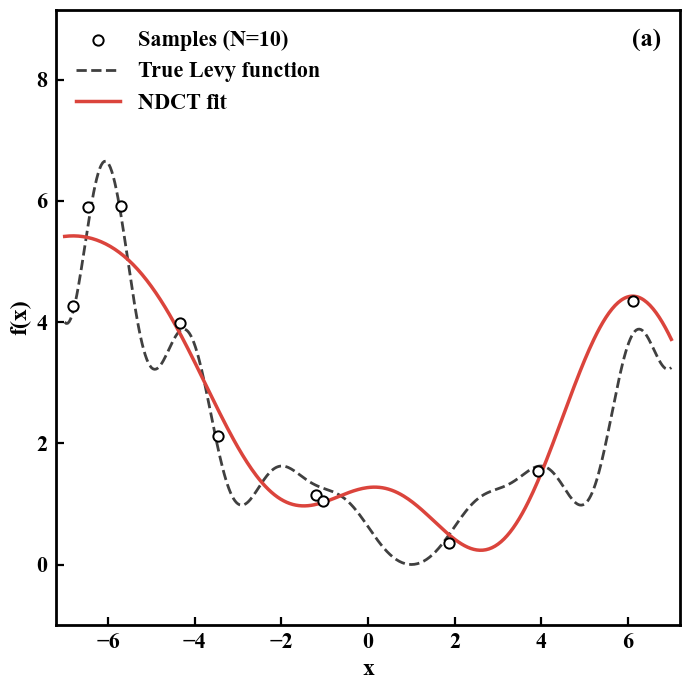

Evaluation results:
[{'Experiment': 'N=10', 'RMSE': 0.5508575186867523, 'MAE': 0.4213125809187668, 'R2': 0.90680966356196}]


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume ndct_fit and rmse have been implemented elsewhere
# from your_module import ndct_fit, rmse

# -------------------------- Levy function (1D) --------------------------
def levy(x):
    """Compute the 1D Levy function."""
    w = 1 + (x - 1) / 4
    return np.sin(np.pi * w)**2 + (w - 1)**2 * (1 + np.sin(2 * np.pi * w)**2)

# -------------------------- Main Demo --------------------------
np.random.seed(34)

# ---------- Step 1: Generate nonequispaced sample points (with noise) ----------
N = 10
L_interval = 7.0  # Common domain for the Levy function, [-10, 10]
x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)  # Nonuniform sampling in [-7, 7]
y_true = levy(x1)  # Ground truth

# Add Gaussian noise
noise_level = 0.3
f = levy(x1) + np.random.normal(0, noise_level, size=N)

# ---------- Step 2: Fit the NDCT model ----------
t_dense = np.linspace(-L_interval, L_interval, 400)   # High-resolution grid
K_dct = 5
model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)
y_hat1 = model_dct.predict(t_dense)
y_pred = model_dct.predict(x1)

# ---------- Step 3: Visualization ----------
fig, ax = plt.subplots(figsize=(7, 7))

# NDCT fit: red solid line
ax.plot(
    t_dense, y_hat1, label="NDCT fit",
    lw=2.5, color="#DB443C", linestyle="-", alpha=1, zorder=2
)

# Ground truth: black dashed line
ax.plot(
    t_dense, levy(t_dense), label="True Levy function",
    lw=2.0, color="black", linestyle="--", alpha=0.75, zorder=1
)

# Samples: hollow black circles
ax.scatter(
    x1, f, s=55, facecolors="white", edgecolors="black",
    linewidths=1.4, marker='o', label=f"Samples (N={N})", zorder=3, alpha=1
)

# Axis labels and style
ax.set_xlabel('x', fontsize=17, fontweight='bold', family='Times New Roman')
ax.set_ylabel('f(x)', fontsize=17, fontweight='bold', family='Times New Roman')
ax.set_xlim(-7.2, L_interval + 0.2)
ax.set_ylim(-1, 9.15)
ax.tick_params(
    axis='both', direction='in', which='both',
    labelsize=16, width=1.6, length=6, pad=6
)

for spine in ax.spines.values():
    spine.set_linewidth(2)

# Legend (placed in white space, slightly smaller font)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    loc='upper left', fontsize=16, frameon=False
)

# Panel label
ax.text(0.97, 0.97, "(a)", transform=ax.transAxes,
        fontsize=18, fontweight="bold", ha="right", va="top")

plt.tight_layout()

# Save as SVG (high resolution)
save_path = r"D:\lib\gali\Manuscript\fig1-1D\a.svg"
plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()

# ---------- Step 4: Evaluation Metrics ----------
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
mae_val = mean_absolute_error(y_true, y_pred)
r2_val = r2_score(y_true, y_pred)

# Store the results
results = []
results.append({"Experiment": f"N={N}", "RMSE": rmse_val, "MAE": mae_val, "R2": r2_val})

# Print evaluation metrics
print("Evaluation results:")
print(results)


# N=100

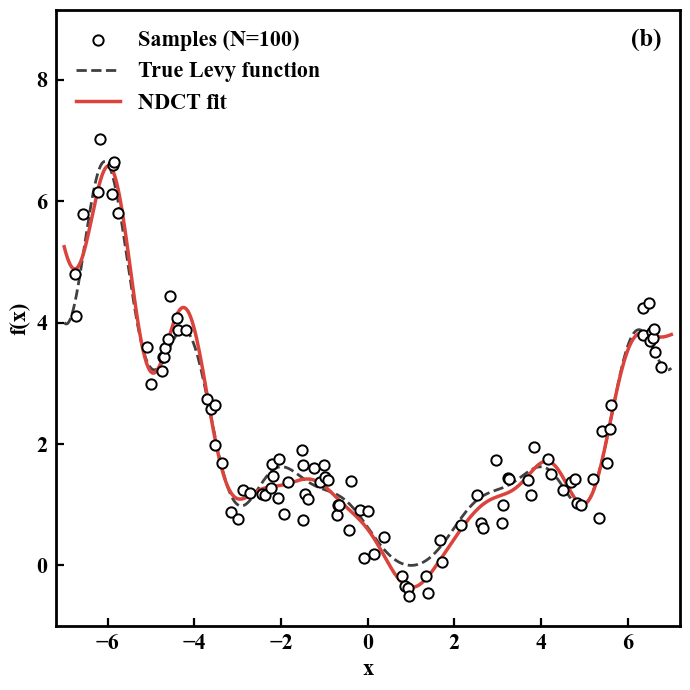

NDCT (N=100, K=18) performance:
  RMSE = 0.1813
  MAE  = 0.1370
  R2   = 0.9870


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume ndct_fit and levy() are already defined elsewhere.
# from your_module import ndct_fit, levy

# -------------------------- Data Generation --------------------------
N = 100
L_interval = 7.0   # Common domain for the Levy function, e.g., [-10, 10]
np.random.seed(33)

# Generate nonuniform sample points in [-L_interval, L_interval]
x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)

# Add Gaussian noise
noise_level = 0.3
f = levy(x1) + np.random.normal(0, noise_level, size=N)
y_true = levy(x1)  # True noiseless values

# -------------------------- NDCT Fitting --------------------------
t_dense = np.linspace(-L_interval, L_interval, 400)  # High-resolution grid
K_dct = 18                                           # Number of cosine basis terms
model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)
y_hat1 = model_dct.predict(t_dense)
y_pred = model_dct.predict(x1)

# -------------------------- Visualization --------------------------
fig, ax = plt.subplots(figsize=(7, 7))

# NDCT fit: red solid line
ax.plot(
    t_dense, y_hat1, label="NDCT fit",
    lw=2.5, color="#DB443C", linestyle="-", alpha=1, zorder=2
)

# Ground truth: black dashed line
ax.plot(
    t_dense, levy(t_dense), label="True Levy function",
    lw=2.0, color="black", linestyle="--", alpha=0.75, zorder=1
)

# Samples: hollow black circles
ax.scatter(
    x1, f, s=55, facecolors="white", edgecolors="black",
    linewidths=1.4, marker='o', label=f"Samples (N={N})", zorder=3, alpha=1
)

# -------------------------- Axis and Style --------------------------
ax.set_xlabel('x', fontsize=16, fontweight='bold', family='Times New Roman')
ax.set_ylabel('f(x)', fontsize=16, fontweight='bold', family='Times New Roman')
ax.set_xlim(-7.2, L_interval + 0.2)
ax.set_ylim(-1, 9.15)
ax.tick_params(
    axis='both', direction='in', which='both',
    labelsize=16, width=1.6, length=6, pad=6
)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Legend (reversed order, slightly smaller font)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    loc='upper left', fontsize=16, frameon=False
)

# Panel label
ax.text(0.97, 0.97, "(b)", transform=ax.transAxes,
        fontsize=18, fontweight="bold", ha="right", va="top")

plt.tight_layout()

# Save figure (SVG format for high-quality publication)
save_path = r"D:\lib\gali\Manuscript\fig1-1D\b.svg"
plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()

# -------------------------- Evaluation Metrics --------------------------
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
mae_val = mean_absolute_error(y_true, y_pred)
r2_val = r2_score(y_true, y_pred)

# Append results
results.append({
    "Experiment": "N=100",
    "RMSE": rmse_val,
    "MAE": mae_val,
    "R2": r2_val
})

# Display metrics
print(f"NDCT (N={N}, K={K_dct}) performance:")
print(f"  RMSE = {rmse_val:.4f}")
print(f"  MAE  = {mae_val:.4f}")
print(f"  R2   = {r2_val:.4f}")


# N=1000

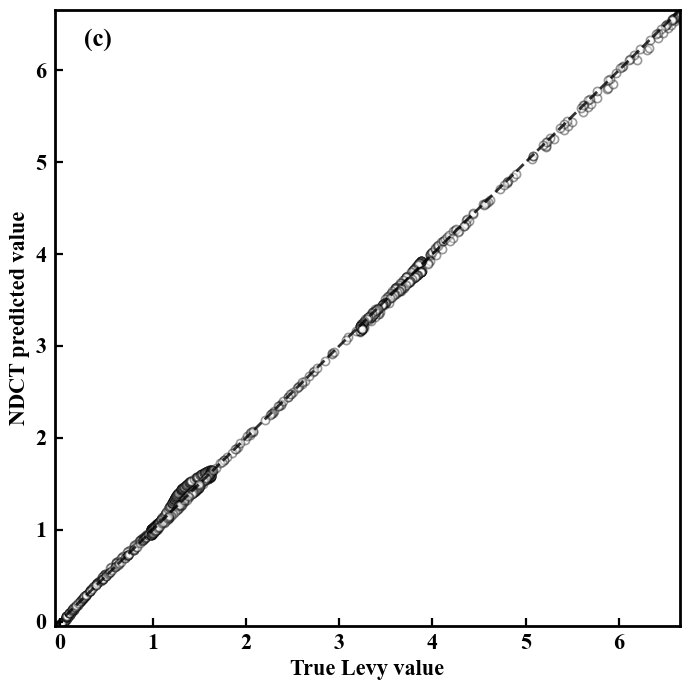

NDCT (N=1000, K=20) performance:
  RMSE = 0.0444
  MAE  = 0.0318
  R2   = 0.9993


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume levy() and ndct_fit() are already implemented
# from your_module import levy, ndct_fit

# -------------------------- Data Preparation --------------------------
N = 1000
L_interval = 7.0   # Common domain for the Levy function, e.g., [-10, 10]
np.random.seed(38)

# Generate nonequispaced sample points
x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)

# Add Gaussian noise
noise_level = 0.3
f = levy(x1) + np.random.normal(0, noise_level, size=N)

# Fit NDCT model
K_dct = 20
model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)

# True and predicted values
y_true = levy(x1)
y_pred = model_dct.predict(x1)

# -------------------------- Visualization --------------------------
fig, ax = plt.subplots(figsize=(7, 7))

# Scatter plot: predicted vs. true values
ax.scatter(
    y_true, y_pred, s=35, facecolors="white", edgecolors="black",
    linewidths=1.2, marker='o', alpha=0.4, label=f"Samples (N={N})"
)

# Reference diagonal (ideal y=x line)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
ax.plot(lims, lims, 'k--', lw=2, alpha=0.8, label="Ideal fit (y=x)")

# Axis configuration
ax.set_xlabel('True Levy value', fontsize=16, fontweight='bold', family='Times New Roman')
ax.set_ylabel('NDCT predicted value', fontsize=16, fontweight='bold', family='Times New Roman')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.tick_params(
    axis='both', direction='in', which='both',
    labelsize=16, width=1.6, length=6, pad=6
)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Panel label
ax.text(0.09, 0.97, "(c)", transform=ax.transAxes,
        fontsize=18, fontweight="bold", ha="right", va="top")

plt.tight_layout()

# Save high-resolution figure (SVG format)
save_path = r"D:\lib\gali\Manuscript\fig1-1D\c.svg"
plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()

# -------------------------- Error Metrics --------------------------
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
mae_val = mean_absolute_error(y_true, y_pred)
r2_val = r2_score(y_true, y_pred)

# Append results
results.append({
    "Experiment": "N=1000",
    "RMSE": rmse_val,
    "MAE": mae_val,
    "R2": r2_val
})

# Display evaluation metrics
print(f"NDCT (N={N}, K={K_dct}) performance:")
print(f"  RMSE = {rmse_val:.4f}")
print(f"  MAE  = {mae_val:.4f}")
print(f"  R2   = {r2_val:.4f}")


In [7]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume levy() and ndct_fit() are already implemented
# from your_module import levy, ndct_fit

# -------------------------- Data Preparation --------------------------
N = 10000
L_interval = 7.0   # Common domain for the Levy function, e.g., [-10, 10]
np.random.seed(38)

# Generate nonequispaced sample points
x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)

# Add Gaussian noise
noise_level = 0.3
f = levy(x1) + np.random.normal(0, noise_level, size=N)

# Fit NDCT model
K_dct = 20
model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)

# Compute predictions
y_true = levy(x1)
y_pred = model_dct.predict(x1)

# -------------------------- Error Metrics --------------------------
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
mae_val = mean_absolute_error(y_true, y_pred)
r2_val = r2_score(y_true, y_pred)

# Append results
results.append({
    "Experiment": "N=10000",
    "RMSE": rmse_val,
    "MAE": mae_val,
    "R2": r2_val
})

# Display evaluation metrics
print(f"NDCT (N={N}, K={K_dct}) performance:")
print(f"  RMSE = {rmse_val:.6f}")
print(f"  MAE  = {mae_val:.6f}")
print(f"  R2   = {r2_val:.6f}")


NDCT (N=10000, K=20) performance:
  RMSE = 0.016984
  MAE  = 0.013692
  R2   = 0.999894


In [8]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume levy() and ndct_fit() are already implemented
# from your_module import levy, ndct_fit

# -------------------------- Data Preparation --------------------------
N = 10000
L_interval = 7.0   # Common domain for the Levy function, e.g., [-10, 10]
np.random.seed(38)

# Generate nonequispaced sample points
x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)

# Add Gaussian noise
noise_level = 0.3
f = levy(x1) + np.random.normal(0, noise_level, size=N)

# Fit NDCT model
K_dct = 22
model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)

# Compute predictions
y_true = levy(x1)
y_pred = model_dct.predict(x1)

# -------------------------- Error Metrics --------------------------
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
mae_val = mean_absolute_error(y_true, y_pred)
r2_val = r2_score(y_true, y_pred)

# Append results
results.append({
    "Experiment": "N=10000",
    "RMSE": rmse_val,
    "MAE": mae_val,
    "R2": r2_val
})

# Display evaluation metrics
print(f"NDCT (N={N}, K={K_dct}) performance:")
print(f"  RMSE = {rmse_val:.6f}")
print(f"  MAE  = {mae_val:.6f}")
print(f"  R2   = {r2_val:.6f}")


NDCT (N=10000, K=22) performance:
  RMSE = 0.017061
  MAE  = 0.013782
  R2   = 0.999893


In [9]:
df_metrics = pd.DataFrame(results)
print(df_metrics)

  Experiment      RMSE       MAE        R2
0       N=10  0.550858  0.421313  0.906810
1      N=100  0.181345  0.137042  0.986954
2     N=1000  0.044425  0.031782  0.999282
3    N=10000  0.016984  0.013692  0.999894
4    N=10000  0.017061  0.013782  0.999893


  Experiment      RMSE       MAE        R2
0       N=10  0.550858  0.421313  0.906810
1      N=100  0.181345  0.137042  0.986954
2     N=1000  0.044425  0.031782  0.999282
3    N=10000  0.016984  0.013692  0.999894
4    N=10000  0.017061  0.013782  0.999893


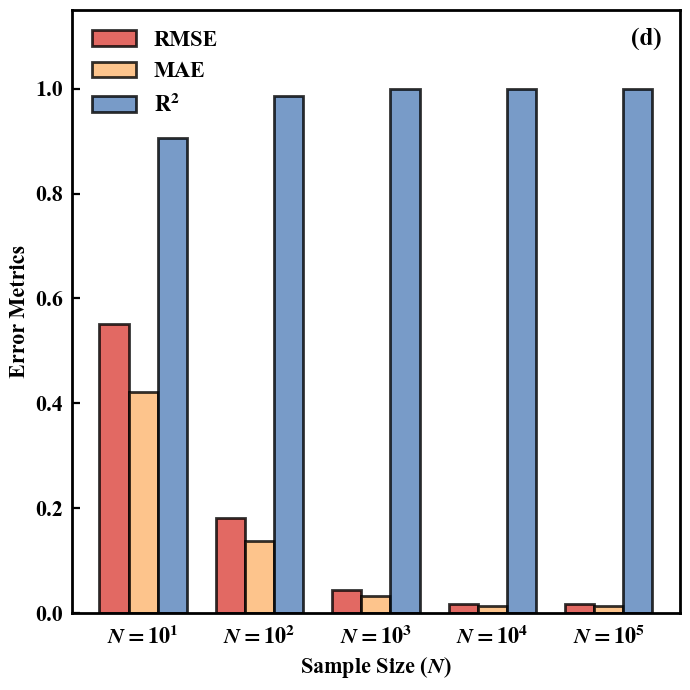

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# -------------------------- Font Configuration --------------------------
# Use STIX math fonts (close to Times New Roman for equations)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'Times New Roman'

# -------------------------- Load Metrics --------------------------
# Assume df_metrics is created from your accumulated results list:
# df_metrics = pd.DataFrame(results)
print(df_metrics)

# Replace experiment labels with LaTeX-styled notation: N = 10^n
exps = [r"$N=10^1$", r"$N=10^2$", r"$N=10^3$", r"$N=10^4$", r"$N=10^5$"]
df_metrics["Experiment"] = exps

# -------------------------- Bar Plot Configuration --------------------------
x = np.arange(len(df_metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(7, 7))

# RMSE bars (red)
ax.bar(
    x - width, df_metrics["RMSE"], width,
    facecolor="#DB443C", edgecolor="black", linewidth=2,
    label="RMSE", alpha=0.8
)

# MAE bars (orange)
ax.bar(
    x, df_metrics["MAE"], width,
    color="#FDB670", edgecolor="black", linewidth=2,
    label="MAE", alpha=0.8
)

# R² bars (blue)
ax.bar(
    x + width, df_metrics["R2"], width,
    color="#5682BB", edgecolor="black", linewidth=2,
    label=r"$\mathrm{R}^2$", alpha=0.8
)

# -------------------------- Axes & Labels --------------------------
ax.set_xticks(x)
ax.set_xticklabels(df_metrics["Experiment"], fontsize=15, family="Times New Roman")
ax.set_xlabel(r"Sample Size ($\boldsymbol{N}$)", fontsize=16, fontweight="bold", family="Times New Roman")
ax.set_ylabel("Error Metrics", fontsize=16, fontweight="bold", family="Times New Roman")
ax.set_ylim(0, 1.15)

# Axis style
ax.tick_params(axis='x', bottom=False, top=False, pad=6, labelsize=16)
ax.tick_params(axis='y', direction='in', which='both', labelsize=16, width=1.6, length=6, pad=6)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# -------------------------- Legend --------------------------
ax.legend(fontsize=16, frameon=False)

# Panel label
ax.text(0.97, 0.97, "(d)", transform=ax.transAxes,
        fontsize=18, fontweight="bold", ha="right", va="top")

plt.tight_layout()

# -------------------------- Save & Display --------------------------
save_path = r"D:\lib\gali\Manuscript\fig1-1D\d.svg"
plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()
